In [ ]:
"""
Quantum Control Dataset Generation Pipeline

This script generates comprehensive training data for quantum control optimization by simulating
quantum system evolution under various control pulses and system parameters. The dataset contains
Fourier coefficients for control pulses and corresponding quantum evolution dynamics.

Features:
    • System parameter variations (ωt, ωr, g)
    • Random control pulse generation
    • Quantum evolution simulation
    • Comprehensive error handling
    • Multiple export formats

Author: Quantum Control Research Team
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import os

from src import (
    time_array, DEFAULT_FOURIER_MODES, QUBIT_FREQUENCY, CAVITY_FREQUENCY, 
    COUPLING_STRENGTH, CAVITY_DISSIPATION, QUBIT_DISSIPATION, QUBIT_DEPHASING,
    simulate_controlled_evolution, get_initial_state, QuantumControlPlotter
)
from src.operators import get_collapse_operators

# Configuration
np.random.seed(42)  # Reproducible results
N_SAMPLES = int(1e4)  # Dataset size

# Initialize visualization
plotter = QuantumControlPlotter(show_plots=True, use_latex=False)

print("=== QUANTUM CONTROL DATASET GENERATION ===")
print(f"📊 Fourier modes: {DEFAULT_FOURIER_MODES}")
print(f"⏰ Time evolution points: {len(time_array)}")
print(f"🎯 Target dataset size: {N_SAMPLES:,} samples")
print("✅ Libraries imported successfully")

# Quantum Control Dataset Generation

This notebook creates a comprehensive dataset for training neural networks to optimize quantum control pulses for single-qubit operations in a cavity-QED system.

## Dataset Components

**System Parameters**
- Qubit transition frequency (ωt)
- Cavity resonance frequency (ωr) 
- Qubit-cavity coupling strength (g)

**Control Signals**
- Fourier coefficients for I/Q control channels
- Randomly generated pulse variations

**Quantum Dynamics**
- Time evolution of expectation values: ⟨σz⟩, ⟨σx⟩, ⟨σy⟩, ⟨n⟩
- Generated control fields in time domain

## Applications
The generated dataset enables training of neural networks for:
- Quantum gate optimization
- Pulse shape engineering
- Robust quantum control design
- Physics-informed machine learning

## 1. Quantum System Initialization

Initialize the quantum system components including:
- Initial quantum state (ground state)
- Dissipation and decoherence operators
- System parameter variations

In [ ]:
class QuantumSystemSetup:
    """Setup quantum system components and generate parameter variations."""
    
    def __init__(self):
        """Initialize quantum system with default parameters."""
        self.init_state = get_initial_state()
        self.collapse_ops = get_collapse_operators(
            gamma_cavity=CAVITY_DISSIPATION,
            gamma_qubit=QUBIT_DISSIPATION,
            gamma_dephasing=QUBIT_DEPHASING
        )
        print("✅ Quantum system initialized")
        print(f"   • Cavity dissipation: {CAVITY_DISSIPATION/(2*np.pi*1e6):.1f} MHz")
        print(f"   • Qubit dissipation: {QUBIT_DISSIPATION/(2*np.pi*1e3):.1f} kHz")
        print(f"   • Qubit dephasing: {QUBIT_DEPHASING/(2*np.pi*1e3):.1f} kHz")
    
    def create_system_parameters(self):
        """Generate realistic system parameters with small variations."""
        return {
            "omega_t": QUBIT_FREQUENCY + np.random.normal(0, 0.01 * 2 * np.pi),
            "omega_r": CAVITY_FREQUENCY + np.random.normal(0, 0.01 * 2 * np.pi),
            "coupling_g": COUPLING_STRENGTH + np.random.normal(0, 0.001 * 2 * np.pi),
        }
    
    def generate_parameter_dataset(self, n_samples=N_SAMPLES):
        """Generate dataset of system parameter variations."""
        return {i: self.create_system_parameters() for i in range(n_samples)}

# Initialize quantum system
quantum_system = QuantumSystemSetup()
sys_params_dataset = quantum_system.generate_parameter_dataset()

print(f"📊 Generated {len(sys_params_dataset):,} parameter variations")
print(f"🔧 Parameters: {list(sys_params_dataset[0].keys())}")

In [ ]:
# Display sample system parameters for verification
print("🔍 Sample system parameters:")
for i, (key, params) in enumerate(list(sys_params_dataset.items())[:3]):
    print(f"   Sample {i+1}: ωt={params['omega_t']/(2*np.pi):.4f} GHz, "
          f"ωr={params['omega_r']/(2*np.pi):.4f} GHz, "
          f"g={params['coupling_g']/(2*np.pi*1e6):.2f} MHz")

# Statistical analysis of parameter variations
all_omega_t = [params['omega_t']/(2*np.pi) for params in sys_params_dataset.values()]
all_omega_r = [params['omega_r']/(2*np.pi) for params in sys_params_dataset.values()]
all_coupling_g = [params['coupling_g']/(2*np.pi*1e6) for params in sys_params_dataset.values()]

print(f"\n📈 Parameter statistics:")
print(f"   • ωt: {np.mean(all_omega_t):.4f} ± {np.std(all_omega_t):.4f} GHz")
print(f"   • ωr: {np.mean(all_omega_r):.4f} ± {np.std(all_omega_r):.4f} GHz")
print(f"   • g:  {np.mean(all_coupling_g):.2f} ± {np.std(all_coupling_g):.2f} MHz")

{0: {'omega_t': 6.050434975016593,
  'omega_r': 19.698790737812946,
  'coupling_g': 0.5772866781209672},
 1: {'omega_t': 6.328250526148694,
  'omega_r': 18.865981398380228,
  'coupling_g': 0.6019372975273454},
 2: {'omega_t': 5.133808022088601,
  'omega_r': 19.06514161513873,
  'coupling_g': 0.6412658815883324},
 3: {'omega_t': 6.38101162461596,
  'omega_r': 18.429834969638563,
  'coupling_g': 0.6657287008710588},
 4: {'omega_t': 6.177193424779741,
  'omega_r': 19.365095711943088,
  'coupling_g': 0.5522964638726282},
 5: {'omega_t': 6.501352739978897,
  'omega_r': 18.535351720155404,
  'coupling_g': 0.5755926637540435},
 6: {'omega_t': 6.6572563385254515,
  'omega_r': 19.468653572244534,
  'coupling_g': 0.6236288445493806},
 7: {'omega_t': 6.261431221322537,
  'omega_r': 19.10733099283917,
  'coupling_g': 0.7163872104925968},
 8: {'omega_t': 6.06066767689033,
  'omega_r': 19.873546050418177,
  'coupling_g': 0.6064571237042667},
 9: {'omega_t': 6.076661212665569,
  'omega_r': 17.7275824

## 2. Quantum Evolution Test

Verify the simulation pipeline with a sample control pulse to ensure proper functionality before generating the full dataset.

In [ ]:
print("🧪 Testing quantum evolution simulation...")

# Create example control pulse with mixed frequency components
control_modes = np.zeros(DEFAULT_FOURIER_MODES)
control_modes[:8] = 0.68   # Lower frequency components (fundamental dynamics)
control_modes[-5:] = 0.32  # Higher frequency components (fine control)

print(f"🎛️ Test pulse: {len(control_modes)} Fourier modes")
print(f"   • Low freq. amplitude: {control_modes[:8].max():.2f}")
print(f"   • High freq. amplitude: {control_modes[-5:].max():.2f}")

# Run test simulation
evolution = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=control_modes,
    drive_period=time_array[-1],
    system_params=sys_params_dataset[0],
    initial_state=quantum_system.init_state, 
    collapse_ops=quantum_system.collapse_ops
)

print(f"✅ Simulation completed successfully")
print(f"📈 Evolution data: {len(evolution['expect'])} observables × {len(evolution['times'])} time points")
print(f"🎯 Observables: σz, σx, σy, n (cavity photons)")

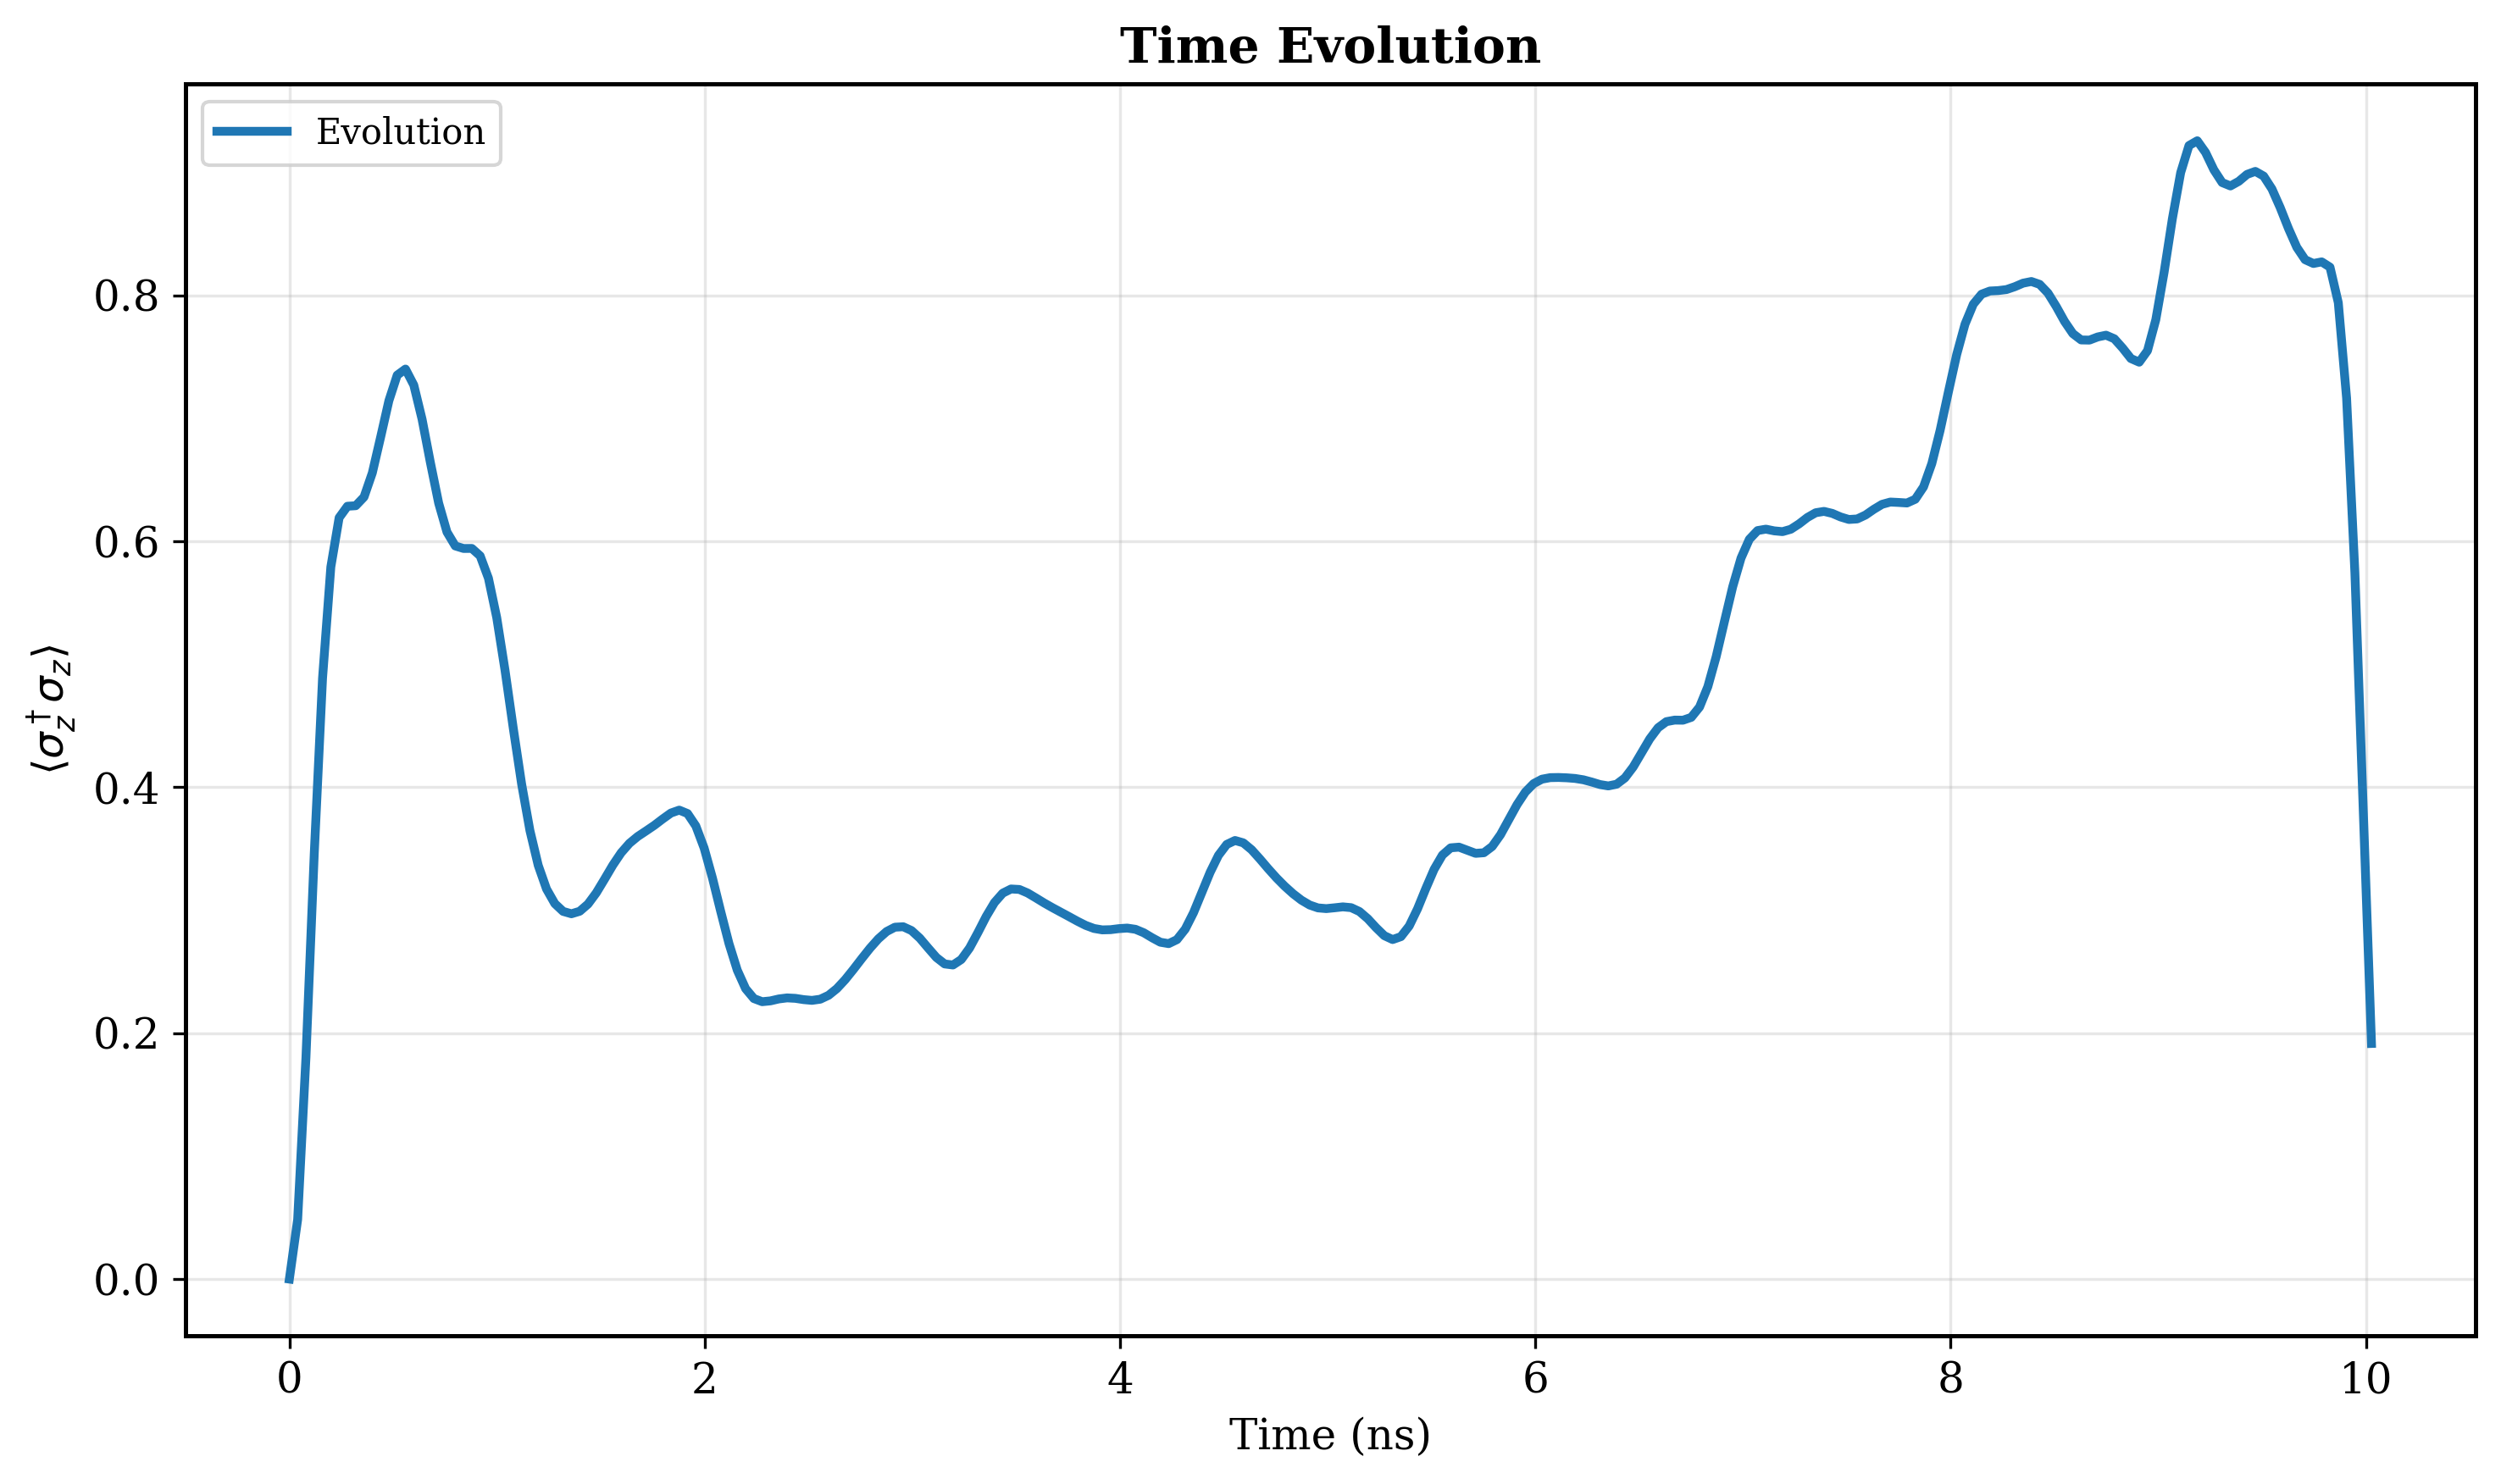

In [ ]:
# Visualize test evolution to verify simulation quality
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Quantum Evolution Test: Expectation Values', fontsize=14, fontweight='bold')

observables = ['⟨σz⟩', '⟨σx⟩', '⟨σy⟩', '⟨n⟩']
for i, (ax, obs_name) in enumerate(zip(axes.flat, observables)):
    ax.plot(time_array, evolution['expect'][i], 'b-', linewidth=2)
    ax.set_xlabel('Time')
    ax.set_ylabel(obs_name)
    ax.grid(True, alpha=0.3)
    ax.set_title(f'{obs_name} Evolution')

plt.tight_layout()
plt.show()

print("📊 Test visualization complete: All quantum observables show proper evolution")

## 3. Control Pulse Generation

Generate random control pulses using Fourier decomposition for both I (in-phase) and Q (quadrature) channels.

In [ ]:
class ControlPulseGenerator:
    """Generate diverse control pulses for comprehensive dataset coverage."""
    
    def __init__(self, fourier_modes=DEFAULT_FOURIER_MODES):
        self.fourier_modes = fourier_modes
        
    def create_random_control_pulse(self, scale_I=0.5, scale_Q=0.5):
        """
        Generate random Fourier coefficients for I/Q control channels.
        
        Args:
            scale_I: Standard deviation for I-channel coefficients
            scale_Q: Standard deviation for Q-channel coefficients
            
        Returns:
            Combined array of I and Q Fourier coefficients
        """
        # Ensure even number of modes for I/Q pairing
        num_modes = self.fourier_modes if self.fourier_modes % 2 == 0 else self.fourier_modes + 1
        half = num_modes // 2
        
        # Generate I and Q coefficients with Gaussian distribution
        coeffs_I = np.random.normal(0.0, scale_I, size=half).astype(float)
        coeffs_Q = np.random.normal(0.0, scale_Q, size=half).astype(float)
        
        return np.concatenate([coeffs_I, coeffs_Q])

# Initialize pulse generator
pulse_generator = ControlPulseGenerator()

print(f"🎛️ Control pulse generator initialized")
print(f"📊 Configuration:")
print(f"   • Fourier modes: {DEFAULT_FOURIER_MODES}")
print(f"   • I/Q channels: {DEFAULT_FOURIER_MODES // 2} modes each")
print(f"   • Target samples: {N_SAMPLES:,}")

# Test pulse generation
example_pulse = pulse_generator.create_random_control_pulse()
print(f"✅ Example pulse generated: shape {example_pulse.shape}")
print(f"   • First 4 I-coeffs: {example_pulse[:4]}")
print(f"   • First 4 Q-coeffs: {example_pulse[DEFAULT_FOURIER_MODES//2:DEFAULT_FOURIER_MODES//2+4]}")

Preparing to simulate 10000 samples with 32 Fourier modes (I/Q split).


In [ ]:
print("🎛️ Generating control pulse library...")

# Pre-generate all control pulses for consistency and efficiency
control_pulses = {}
for i in tqdm(range(N_SAMPLES), desc="Generating pulses"):
    control_pulses[i] = pulse_generator.create_random_control_pulse()

print(f"✅ Generated {len(control_pulses):,} control pulses")

# Analyze pulse statistics
all_pulses = list(control_pulses.values())
mean_amplitudes = [np.mean(np.abs(pulse)) for pulse in all_pulses[:1000]]  # Sample subset
std_amplitudes = [np.std(pulse) for pulse in all_pulses[:1000]]

print(f"📊 Pulse statistics (sample of 1,000):")
print(f"   • Shape per pulse: {all_pulses[0].shape}")
print(f"   • Mean |amplitude|: {np.mean(mean_amplitudes):.4f} ± {np.std(mean_amplitudes):.4f}")
print(f"   • RMS variation: {np.mean(std_amplitudes):.4f} ± {np.std(std_amplitudes):.4f}")
print(f"   • Dynamic range: [{np.min([p.min() for p in all_pulses[:100]]):.3f}, {np.max([p.max() for p in all_pulses[:100]]):.3f}]")

(32, array([ 0.24835708, -0.06913215,  0.32384427,  0.76151493]))

## 4. Dataset Generation Pipeline

Execute comprehensive quantum simulations for all parameter-pulse combinations with robust error handling and progress tracking.

In [ ]:
class DatasetGenerator:
    """High-performance dataset generation with comprehensive error handling."""
    
    def __init__(self, quantum_system):
        self.quantum_system = quantum_system
        self.drive_period = float(time_array[-1])
        self.records = []
        self.success_count = 0
        self.error_count = 0
        
    def create_simulation_record(self, index, params, coeffs):
        """Execute single quantum simulation with error handling."""
        try:
            result = simulate_controlled_evolution(
                time_array,
                fourier_coefficients=coeffs,
                drive_period=self.drive_period,
                system_params=params,
                initial_state=self.quantum_system.init_state,
                collapse_ops=self.quantum_system.collapse_ops
            )
            
            # Extract and validate results
            expect = result.get("expect", [])
            times = result.get("times", time_array)
            control_fields = result.get("control_fields", {})
            
            # Ensure data consistency
            if len(expect) < 4:
                raise ValueError(f"Incomplete expectation values: {len(expect)}/4")
            
            # Build record with type safety
            record = {
                "index": int(index),
                "omega_t": float(params["omega_t"]),
                "omega_r": float(params["omega_r"]),
                "coupling_g": float(params["coupling_g"]),
                "coeffs": coeffs.tolist(),
                "times": np.asarray(times, dtype=float).tolist(),
                "expect_z": np.asarray(expect[0], dtype=float).tolist(),
                "expect_x": np.asarray(expect[1], dtype=float).tolist(),
                "expect_y": np.asarray(expect[2], dtype=float).tolist(),
                "expect_n": np.asarray(expect[3], dtype=float).tolist(),
                "control_I": np.asarray(control_fields.get("I", []), dtype=float).tolist(),
                "control_Q": np.asarray(control_fields.get("Q", []), dtype=float).tolist(),
                "control_composite": np.asarray(control_fields.get("composite", []), dtype=float).tolist(),
            }
            
            self.success_count += 1
            return record
            
        except Exception as e:
            self.error_count += 1
            return {
                "index": int(index),
                "omega_t": float(params["omega_t"]),
                "omega_r": float(params["omega_r"]),
                "coupling_g": float(params["coupling_g"]),
                "coeffs": coeffs.tolist(),
                "error": str(e)
            }
    
    def generate_dataset(self, sys_params_dataset, control_pulses):
        """Execute complete dataset generation with progress monitoring."""
        print("🚀 Starting comprehensive dataset generation...")
        print(f"   • Total simulations: {len(sys_params_dataset):,}")
        print(f"   • Time evolution points: {len(time_array)}")
        print(f"   • Expected data size: ~{len(sys_params_dataset) * len(time_array) * 8 / 1024**2:.1f} MB")
        
        with tqdm(total=len(sys_params_dataset), desc="Quantum simulations") as pbar:
            for i in range(len(sys_params_dataset)):
                params = sys_params_dataset[i]
                coeffs = control_pulses[i]
                record = self.create_simulation_record(i, params, coeffs)
                self.records.append(record)
                
                # Update progress with statistics
                if (i + 1) % 1000 == 0:
                    success_rate = self.success_count / (i + 1) * 100
                    pbar.set_postfix({"Success": f"{success_rate:.1f}%"})
                pbar.update(1)
        
        print(f"✅ Dataset generation completed!")
        print(f"   • Successful simulations: {self.success_count:,}")
        print(f"   • Failed simulations: {self.error_count:,}")
        print(f"   • Success rate: {self.success_count/(self.success_count + self.error_count)*100:.2f}%")
        
        return self.records

# Execute dataset generation
dataset_generator = DatasetGenerator(quantum_system)
records = dataset_generator.generate_dataset(sys_params_dataset, control_pulses)

Simulating:   0%|          | 0/10000 [00:00<?, ?it/s]

10000

## 5. Dataset Export and Validation

Export the generated dataset to optimized formats with comprehensive validation and quality checks.

In [ ]:
class DatasetExporter:
    """Professional dataset export with validation and optimization."""
    
    def __init__(self, output_dir="data"):
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)
        print(f"📁 Output directory: {os.path.abspath(self.output_dir)}")
        
    def create_dataframe(self, records):
        """Create optimized DataFrame with proper column structure."""
        # Define expected columns
        base_columns = [
            "index", "omega_t", "omega_r", "coupling_g", "coeffs", "times",
            "expect_z", "expect_x", "expect_y", "expect_n",
            "control_I", "control_Q", "control_composite"
        ]
        
        # Add error column if needed
        has_errors = any('error' in record for record in records)
        columns = base_columns + (["error"] if has_errors else [])
        
        return pd.DataFrame(records, columns=columns)
    
    def validate_dataset(self, df):
        """Comprehensive dataset validation and quality assessment."""
        print("🔍 Dataset Validation Report:")
        print("=" * 40)
        
        # Basic statistics
        print(f"📊 Shape: {df.shape[0]:,} samples × {df.shape[1]} features")
        print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
        
        # Data quality checks
        successful_samples = df[df['error'].isna()] if 'error' in df.columns else df
        print(f"✅ Successful samples: {len(successful_samples):,}")
        
        if 'error' in df.columns:
            failed_samples = df[df['error'].notna()]
            print(f"❌ Failed samples: {len(failed_samples):,}")
            print(f"📈 Success rate: {len(successful_samples)/len(df)*100:.2f}%")
        
        # Validate sample integrity
        if len(successful_samples) > 0:
            sample = successful_samples.iloc[0]
            print(f"\n? Sample validation:")
            print(f"   • Expectation values length: {len(sample['expect_z'])}")
            print(f"   • Fourier coefficients: {len(sample['coeffs'])}")
            print(f"   • Time points: {len(sample['times'])}")
            
            # Check for NaN values in critical columns
            critical_cols = ['expect_z', 'expect_x', 'expect_y', 'expect_n']
            for col in critical_cols:
                if sample[col] is not None:
                    has_nan = np.any(np.isnan(sample[col]))
                    print(f"   • {col} contains NaN: {'Yes' if has_nan else 'No'}")
        
        return len(successful_samples) > 0
    
    def export_to_parquet(self, df, filename="quantum_control_dataset.parquet"):
        """Export to efficient Parquet format with compression."""
        filepath = os.path.join(self.output_dir, filename)
        
        # Export with optimized settings
        df.to_parquet(
            filepath, 
            engine="pyarrow", 
            index=False,
            compression="snappy"  # Good balance of speed and compression
        )
        
        file_size_mb = os.path.getsize(filepath) / 1024**2
        print(f"💾 Dataset exported: {filename}")
        print(f"   • File size: {file_size_mb:.1f} MB")
        print(f"   • Compression ratio: {df.memory_usage(deep=True).sum() / 1024**2 / file_size_mb:.1f}:1")
        
        return filepath

# Execute export pipeline
print("📦 DATASET EXPORT PIPELINE")
print("=" * 40)

exporter = DatasetExporter()
df = exporter.create_dataframe(records)

# Validate dataset quality
if exporter.validate_dataset(df):
    print("\n✅ Dataset validation passed")
    
    # Export to Parquet format
    parquet_path = exporter.export_to_parquet(df)
    print(f"🎯 Export completed: {os.path.basename(parquet_path)}")
else:
    print("\n❌ Dataset validation failed - check error logs")

Saved dataset: /home/denysderlian/projects/tgRepo_qubitControl/data/quantum_control_dataset.parquet
Rows: 10000 Columns: ['index', 'omega_t', 'omega_r', 'coupling_g', 'coeffs', 'times', 'expect_z', 'expect_x', 'expect_y', 'expect_n', 'control_I', 'control_Q', 'control_composite', 'error']


In [ ]:
# Generate comprehensive dataset overview
print("\n📊 FINAL DATASET OVERVIEW")
print("=" * 50)

# Summary statistics
total_samples = len(df)
successful_samples = len(df[df['error'].isna()]) if 'error' in df.columns else total_samples
failed_samples = len(df[df['error'].notna()]) if 'error' in df.columns else 0

print(f"🎯 Dataset Summary:")
print(f"   • Total samples: {total_samples:,}")
print(f"   • Successful simulations: {successful_samples:,}")
print(f"   • Failed simulations: {failed_samples:,}")
print(f"   • Success rate: {successful_samples / total_samples * 100:.2f}%")

print(f"\n📋 Data Structure:")
print(f"   • Features per sample: {df.shape[1]}")
print(f"   • Time evolution points: {len(df.iloc[0]['times']) if df.iloc[0]['times'] else 'N/A'}")
print(f"   • Fourier modes: {len(df.iloc[0]['coeffs']) if df.iloc[0]['coeffs'] else 'N/A'}")

# Display sample of the dataset
print(f"\n🔍 Sample Records:")
display_df = df[['index', 'omega_t', 'omega_r', 'coupling_g']].head(3)
for col in ['omega_t', 'omega_r']:
    display_df[col] = display_df[col] / (2*np.pi)  # Convert to GHz
display_df['coupling_g'] = display_df['coupling_g'] / (2*np.pi*1e6)  # Convert to MHz

print(display_df.round(4))

print(f"\n🎉 Dataset generation pipeline completed successfully!")
print(f"📁 Ready for machine learning training and analysis")

,index,omega_t,omega_r,coupling_g,coeffs,times,expect_z,expect_x,expect_y,expect_n,control_I,control_Q,control_composite,error
0,0,5.370713,18.981634,0.636007,"[-0.0067486123689669605, -0.5288554644779502, ...","[0.0, 0.03994725663262712, 0.07989451326525424...","[1.0, 0.9743792492469651, 0.8974353780913785, ...","[0.0, 0.02390727214044081, 0.09469825572047358...","[0.0, 0.22363741497154394, 0.43085833853352307...","[0.0, 0.012810375376517583, 0.0512823109543107...","[-2.730219046880575, -2.6321679163687333, -2.3...","[-0.0, -0.29074649781261586, -0.52670421242426...","[-2.730219046880575, -2.922914414181349, -2.87...",NaN
1,1,7.270074,18.443154,0.618118,"[0.406262911197099, 0.6781200142854115, -0.036...","[0.0, 0.03994725663262712, 0.07989451326525424...","[1.0, 0.9961286417942338, 0.9871418377522521, ...","[0.0, -0.012995334270238206, -0.04836496835174...","[0.0, -0.08694155923873076, -0.152353854410384...","[0.0, 0.0019356791028829654, 0.006429081123873...","[1.1697218331950252, 1.1266796428138426, 1.002...","[-0.0, -0.09744721666005744, -0.17417324280854...","[1.1697218331950252, 1.0292324261537857, 0.828...",NaN
2,2,5.795312,19.535528,0.624129,"[0.14806013853228803, 0.13052763608994467, 0.0...","[0.0, 0.03994725663262712, 0.07989451326525424...","[1.0, 0.9981335329852595, 0.9972667609624508, ...","[0.0, 0.007952778976870627, 0.0240347420669240...","[0.0, 0.060547997963933696, 0.0698652994471574...","[0.0, 0.0009332335073703386, 0.001366619518774...","[-1.0559788673265724, -1.0136222076884178, -0....","[0.0, 0.5454182468790248, 1.0315549253359813, ...","[-1.0559788673265724, -0.46820396080939286, 0....",NaN
3,3,5.822158,19.258948,0.669659,"[0.04982568254382061, -0.2517378270580996, -0....","[0.0, 0.03994725663262712, 0.07989451326525424...","[1.0, 0.9923494230832353, 0.9742137298654302, ...","[0.0, 0.014602071474514845, 0.0549141443607323...","[0.0, 0.12259462191477587, 0.21884193803002816...","[0.0, 0.0038252884583823833, 0.012893135067284...","[-1.6275172261722075, -1.5601744471167691, -1....","[0.0, 0.1032057163601905, 0.1964701344425589, ...","[-1.6275172261722075, -1.4569687307565782, -1....",NaN
4,4,6.822553,18.662034,0.637667,"[-0.4873408351136607, 0.393542301871226, 0.579...","[0.0, 0.03994725663262712, 0.07989451326525424...","[1.0, 0.9922717093341964, 0.967360469554994, 0...","[0.0, -0.016528552482017976, -0.06685050979531...","[0.0, -0.12297892143350507, -0.244427073736910...","[0.0, 0.0038641453329018665, 0.016319765222502...","[1.4544008559086712, 1.398548122610517, 1.2378...","[0.0, 0.2494089817994464, 0.45965303302905214,...","[1.4544008559086712, 1.6479571044099637, 1.697...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,5.832841,18.851845,0.723948,"[-0.30187918436556355, 1.312313339581372, -0.2...","[0.0, 0.03994725663262712, 0.07989451326525424...","[1.0, 0.9649686668103731, 0.8858233712759674, ...","[0.0, -0.03135043785156779, -0.115623403910137...","[0.0, -0.2604849940128936, -0.449380048895767,...","[0.0, 0.017515666594813593, 0.0570883143620163...","[3.532868475042509, 3.396508194801425, 3.00457...","[-0.0, -0.3100689425891319, -0.587746368031137...","[3.532868475042509, 3.086439252212293, 2.41682...",NaN
996,996,6.593250,18.598952,0.633056,"[0.6585109872402954, -0.08684668775547245, 0.1...","[0.0, 0.03994725663262712, 0.07989451326525424...","[1.0, 0.9692919852569716, 0.8912088498676439, ...","[0.0, -0.032736044776708426, -0.12374918433868...","[0.0, -0.24372370884061323, -0.436381292712664...","[0.0, 0.015354007371514013, 0.0543955750661780...","[3.1820109869267776, 3.0596862153676625, 2.708...","[-0.0, -0.042084603186434304, -0.0660292215670...","[3.1820109869267776, 3.017601612181229, 2.6420...",NaN
997,997,6.187330,18.717776,0.593438,"[-0.28349958383852353, -1.068724353199897, -0....","[0.0, 0.03994725663262712, 0.07989451326525424...","[1.0, 0.9910464656338345, 0.9480535206874123, ...","[0.0, 0.015127216766818078, 0.0693001504362268...","[0.0, 0.1326585117536125, 0.3104

## 6. Dataset Analysis and Quality Assessment

Perform detailed analysis of the generated dataset to ensure quality and completeness for machine learning applications.

In [ ]:
# Comprehensive dataset analysis
print("🔬 DETAILED DATASET ANALYSIS")
print("=" * 50)

# Dataset structure analysis
print(f"📊 Dataset Structure:")
print(f"   • Shape: {df.shape}")
print(f"   • Columns: {list(df.columns)}")
print(f"   • Data types: {dict(df.dtypes)}")

# Analyze successful samples only
successful_df = df[df['error'].isna()] if 'error' in df.columns else df

if len(successful_df) > 0:
    sample_row = successful_df.iloc[0]
    
    print(f"\n🎯 Sample Analysis:")
    print(f"   • System parameters:")
    print(f"     - ωt: {sample_row['omega_t']/(2*np.pi):.6f} GHz")
    print(f"     - ωr: {sample_row['omega_r']/(2*np.pi):.6f} GHz") 
    print(f"     - g:  {sample_row['coupling_g']/(2*np.pi*1e6):.3f} MHz")
    
    print(f"   • Data arrays:")
    print(f"     - Fourier coefficients: {len(sample_row['coeffs'])} modes")
    print(f"     - Time evolution: {len(sample_row['times'])} points")
    print(f"     - Expectation values: 4 observables × {len(sample_row['expect_z'])} points")
    
    # Check data quality
    expect_arrays = [sample_row['expect_z'], sample_row['expect_x'], 
                    sample_row['expect_y'], sample_row['expect_n']]
    
    print(f"   • Data quality:")
    for i, (obs, data) in enumerate(zip(['σz', 'σx', 'σy', 'n'], expect_arrays)):
        if data is not None:
            data_array = np.array(data)
            has_nan = np.any(np.isnan(data_array))
            data_range = f"[{data_array.min():.3f}, {data_array.max():.3f}]"
            print(f"     - ⟨{obs}⟩: Range {data_range}, NaN: {'Yes' if has_nan else 'No'}")

    # Parameter distribution analysis
    print(f"\n📈 Parameter Distributions:")
    param_stats = {}
    for param in ['omega_t', 'omega_r', 'coupling_g']:
        values = successful_df[param].values
        param_stats[param] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values)
        }
    
    for param, stats in param_stats.items():
        unit = "GHz" if param in ['omega_t', 'omega_r'] else "MHz"
        scale = 2*np.pi if param in ['omega_t', 'omega_r'] else 2*np.pi*1e6
        print(f"   • {param}: {stats['mean']/scale:.4f} ± {stats['std']/scale:.4f} {unit}")

print(f"\n✅ Dataset analysis completed - Ready for ML training!")
print(f"🚀 Next steps: Load dataset with pd.read_parquet() for training")

Dataset shape: (10000, 14)

Columns: ['index', 'omega_t', 'omega_r', 'coupling_g', 'coeffs', 'times', 'expect_z', 'expect_x', 'expect_y', 'expect_n', 'control_I', 'control_Q', 'control_composite', 'error']

Data types:
index                  int64
omega_t              float64
omega_r              float64
coupling_g           float64
coeffs                object
times                 object
expect_z              object
expect_x              object
expect_y              object
expect_n              object
control_I             object
control_Q             object
control_composite     object
error                float64
dtype: object

Sample of first row:
omega_t: 6.355516435196404
omega_r: 18.456497387891957
coupling_g: 0.5479326359717075
coeffs length: 32
expect_z length: 252
expect_x length: 252
expect_y length: 252
expect_n length: 252
